In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [2]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
df_test_trans = pd.read_csv('../input/test_transaction.csv')

df_train_identity = pd.read_csv('../input/train_identity.csv')
df_test_identity = pd.read_csv('../input/test_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')
df_test = df_test_trans.merge(df_test_identity, how='left', on='TransactionID')

print(df_train.shape)
print(df_test.shape)

# Standardizing column names
df_train.columns = df_train.columns.str.replace('-', '_')
df_test.columns = df_test.columns.str.replace('-', '_')

del df_train_trans, df_train_identity


(590540, 434)
(506691, 433)


In [ ]:
for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype == 'object': 
        # Replace missing values (NaN) with a placeholder string (e.g., "<missing>")
        df_train[f].fillna('<missing>', inplace=True)

for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype=='object': 
        lbl = LabelEncoder()
        df_train[f] = lbl.fit_transform(df_train[f])

df_train.fillna(-999, inplace=True)

X_train = df_train.select_dtypes(include=['number']).drop(columns=['isFraud'])
y_train = df_train['isFraud']  # This is the target variable

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

In [25]:
count_minus_999 = (df_train == -999).sum()

# Sort the result in descending order
count_minus_999_sorted_desc = count_minus_999.sort_values(ascending=False)

# Display the sorted result
print(count_minus_999_sorted_desc)

id_24         585793
id_25         585408
id_08         585385
id_07         585385
id_21         585381
               ...  
id_36              0
id_37              0
id_38              0
DeviceType         0
DeviceInfo         0
Length: 434, dtype: int64


In [15]:
# Build a Neural Network Model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train_scaled.shape[1],)))

# Hidden Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


Epoch 1/20
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6305 - loss: 0.7042 - val_accuracy: 0.7523 - val_loss: 0.6916
Epoch 2/20
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8483 - loss: 0.6842 - val_accuracy: 0.8357 - val_loss: 0.7220
Epoch 3/20
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7776 - loss: 0.6890 - val_accuracy: 0.9593 - val_loss: 0.6818
Epoch 4/20
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8722 - loss: 0.6871 - val_accuracy: 0.9493 - val_loss: 0.6729
Epoch 5/20
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9152 - loss: 0.6796 - val_accuracy: 0.9433 - val_loss: 0.6850
Epoch 6/20
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9329 - loss: 0.6846 - val_accuracy: 0.9607 - val_loss: 0.6804
Epoch 7/20
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9575 - loss: 0.6842 - val_accuracy: 0.9576 - val_loss: 0.6878
Epoch 8/20
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9387 - loss: 0.6832 -

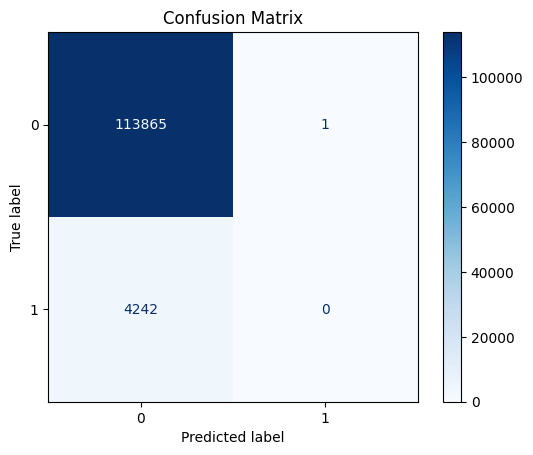

In [14]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

history = model.fit(X_train_scaled, y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.2, 
                    verbose=1,
                    class_weight=class_weights)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_val_scaled)  # Predict probabilities

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()